# Export analysis grid tiles from an `odc-geo` GridSpec

In [1]:
cd ../..

/home/jovyan/Robbi/dea-intertidal


In [2]:
import pandas as pd
import geopandas as gpd

from odc.geo.geom import BoundingBox
from odc.geo.gridspec import GridSpec
from odc.geo.types import xy_


def id_to_tuple(id_str):
    """
    Converts a tile ID in form 'x143y56' to a ix, iy tuple so it can
    be passed to a GridSpec (e.g. `gs[ix, iy]`)
    """
    ix, iy = id_str.replace("x", "").split("y")
    return int(ix), int(iy)

## Create GridSpec tile grid

In [3]:
# Load Collection 3 summary grid, reproject to Albers
c3_path = "https://data.dea.ga.gov.au/derivative/ga_summary_grid_c3.geojson"
c3_grid = gpd.read_file(c3_path)

# Extract BoundingBox, converting to ints to avoid floating point issues
c3_bbox = BoundingBox(
    *c3_grid.to_crs("EPSG:3577").total_bounds.round().astype(int), crs="EPSG:3577"
)
c3_bbox

BoundingBox(left=-2400000, bottom=-5088000, right=2784000, top=-864000, crs=CRS('EPSG:3577'))

In [4]:
# Create 32 km tiles using gridspec, using origin used by C3 grid to
# preserve positive indices
gs_32km = GridSpec(
    crs="EPSG:3577",
    resolution=10,
    tile_shape=(3200, 3200),
    origin=xy_(-2688000, -5472000),
)
gs_32km

GridSpec(crs=EPSG:3577, tile_shape=Shape2d(x=3200, y=3200), resolution=Resolution(x=10, y=-10))

## Create vector file outputs

In [5]:
# Convert grid to geopandas polygon dataset covering full C3 grid extent
grid_gdf = gpd.GeoDataFrame.from_features(
    gs_32km.geojson(bbox=c3_bbox), crs="EPSG:4326"
).to_crs("EPSG:3577")

# Update column names to match C3 grid
grid_gdf[["ix", "iy"]] = grid_gdf.idx.str.split(",", expand=True).astype(int)
grid_gdf["id"] = "x" + grid_gdf.ix.astype(str) + "y" + grid_gdf.iy.astype(str)

# Copy Collection 3 grid, then slightly shrink geometry to make sure we
# have no ambiguity along grid cell edges for the subsequent spatial join
c3_grid_shrunk = c3_grid[["region_code", "utc_offset", "geometry"]].to_crs("EPSG:3577")
c3_grid_shrunk["geometry"] = c3_grid_shrunk.geometry.buffer(-0.01)

# Spatially join attributes from Collection 3 grid to new grid, and
# select a subset of desired columns
grid_gdf_joined = grid_gdf.sjoin(c3_grid_shrunk)[
    ["id", "ix", "iy", "region_code", "utc_offset", "geometry"]
].set_index("id")

### Join GEODATA Topo 100k attributes

In [6]:
region_path = "/gdata1/data/boundaries/GEODATA_COAST_100K/australia/cstauscd_r.shp"
region_gdf = gpd.read_file(region_path).to_crs("EPSG:3577")
region_gdf = region_gdf[["FEAT_CODE", "geometry"]].set_index("FEAT_CODE")


In [7]:
# Identify mainland tiles, and add to "type" field
grid_gdf_mainland = grid_gdf_joined.clip(region_gdf.loc[["mainland"]])
grid_gdf_joined["type"] = "offshore"
grid_gdf_joined.loc[grid_gdf_mainland.index, "type"] = "mainland"

### Subset and clip to the coast

#### Load individual datasets

In [8]:
# GA GEODATA COAST 100K "coastline" features
goadata100k_gdf = (
    gpd.read_file("/gdata1/data/boundaries/GEODATA_COAST_100K/australia/cstauscd_l.shp")
    .query("FEAT_CODE == 'coastline'")
    .to_crs("EPSG:3577")
)

In [9]:
# Non-"mainland" features from Complete Great Barrier Reef (GBR) Island
# and Reef Feature boundaries including Torres Strait Version 1b
# https://eatlas.org.au/data/uuid/d2396b2c-68d4-4f4b-aab0-52f7bc4a81f5
gbrreefs_gdf = (
    gpd.read_file(
        "/gdata1/data/reefs/TS_AIMS_NESP_Torres_Strait_Features_V1b_with_GBR_Features.shp"
    )
    .query("FEAT_NAME != 'Mainland'")
    .to_crs("EPSG:3577")
)
gbrreefs_gdf["geometry"] = gbrreefs_gdf.boundary

In [10]:
# Coral Sea reefs (-10 m contour) from Coral Sea features satellite 
# imagery and raw depth contours (Sentinel 2 and Landsat 8) 2015 – 2021 
# https://eatlas.org.au/data/uuid/df5a5b47-ad4c-431e-be49-af52f64aafce
coralseareefs_gdf = (
    gpd.read_file("/gdata1/data/reefs/CS_AIMS_Coral-Sea-Features_Img_L8_R1_Depth10m_Coral-Sea.shp")
    .to_crs("EPSG:3577")
)

In [11]:
# Additional manually drawn features to capture remote reefs off WA/Qld
additionalislands_gdf = (
    gpd.read_file(
        "data/raw/additional_islands.geojson"
    )
    .to_crs("EPSG:3577"))


#### Combine and select coastal grid cells

In [12]:
# Combine into a single dataset
coastlines_gdf = pd.concat(
    [
        goadata100k_gdf[["geometry"]],
        gbrreefs_gdf[["geometry"]],
        coralseareefs_gdf[["geometry"]],
        additionalislands_gdf[["geometry"]],
    ],
)

# Keep only grid cells within 1000 m of coastlines
grid_gdf_coastal = (
    gpd.sjoin_nearest(grid_gdf, coastlines_gdf, max_distance=1000)
    .groupby("idx")
    .first()
    .drop("index_right", axis=1)
    .set_crs("EPSG:3577")
)
grid_gdf_coastal

,geometry,ix,iy,id
idx,,,,
"100,117","POLYGON ((512000.000 -1696000.000, 512000.000 ...",100,117,x100y117
"100,118","POLYGON ((512000.000 -1664000.000, 512000.000 ...",100,118,x100y118
"100,119","POLYGON ((512000.000 -1632000.000, 512000.000 ...",100,119,x100y119
"100,123","POLYGON ((512000.000 -1504000.000, 512000.000 ...",100,123,x100y123
"100,124","POLYGON ((512000.000 -1472000.000, 512000.000 ...",100,124,x100y124
...,...,...,...,...
"99,53","POLYGON ((480000.000 -3744000.000, 480000.000 ...",99,53,x99y53
"99,54","POLYGON ((480000.000 -3712000.000, 480000.000 ...",99,54,x99y54
"99,55","POLYGON ((480000.000 -3680000.000, 480000.000 ...",99,55,x99y55


<Axes: >

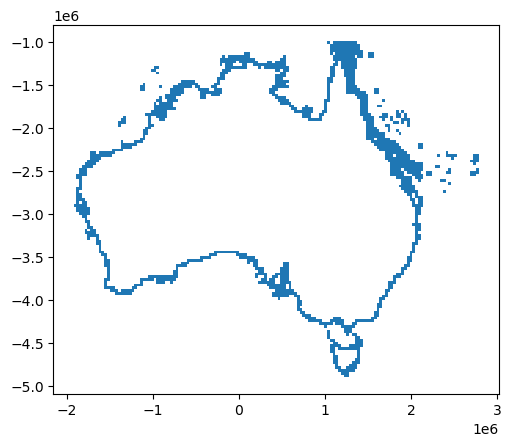

In [13]:
grid_gdf_coastal.plot()

#### Clip grid cells (to do)

In [14]:
# mask_path = "https://data.dea.ga.gov.au/derivative/dea_coastlines/supplementary/albers_grids/coastal_mask_15km.geojson"
# coastal_mask_gdf = gpd.read_file(mask_path)

In [15]:
# # Clip to coastal zone using mask
# grid_gdf_clipped = grid_gdf_joined.clip(coastal_mask_gdf)

### Export all outputs

In [17]:
grid_gdf_joined.to_crs("EPSG:4326").to_file("data/raw/ga_summary_grid_c3_32km.geojson")
grid_gdf_coastal.to_crs("EPSG:4326").to_file("data/raw/ga_summary_grid_c3_32km_coastal.geojson")
# grid_gdf_clipped.to_file("ga_summary_grid_c3_32km_coastal_clipped.geojson")

## Test GridSpec

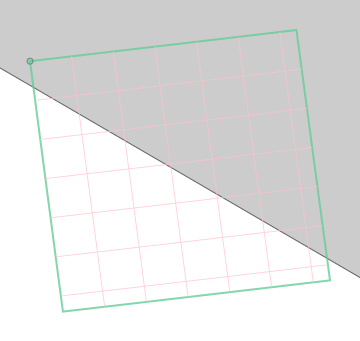

In [18]:
# Test the gridspec on a tile ID
gs_32km[id_to_tuple("x135y101")]

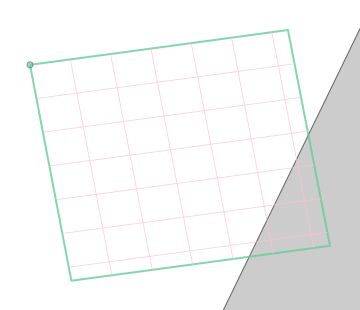

In [19]:
# Test gridspec on coordinates
gs_32km[gs_32km.pt2idx(x=1904005, y=-3664005)]